# PROJECT : Mammography Classification Using CNNs

DATASET: THE MIAS-MAMMOGRAPHY DATASET

INFORMATION:

This file lists the films in the MIAS database and provides     
appropriate details as follows:

1st column: MIAS database reference number.

2nd column: Character of background tissue: 
                F - Fatty 
                G - Fatty-glandular
                D - Dense-glandular

3rd column: Class of abnormality present:
                CALC - Calcification
                CIRC - Well-defined/circumscribed masses
                SPIC - Spiculated masses
                MISC - Other, ill-defined masses
                ARCH - Architectural distortion
                ASYM - Asymmetry
                NORM - Normal

4th column: Severity of abnormality;
                B - Benign
                M - Malignant
                
5th,6th columns: x,y image-coordinates of centre of abnormality.

7th column: Approximate radius (in pixels) of a circle enclosing
            the abnormality.
            
NOTES

1- The list is arranged in pairs of films, where each pair 
   represents the left (even filename numbers) and right mammograms
   (odd filename numbers) of a single patient.
   
2- The size of ALL the images is 1024 pixels x 1024 pixels. The images
   have been centered in the matrix.  

3- When calcifications are present, centre locations and radii 
   apply to clusters rather than individual calcifications.
   Coordinate system origin is the bottom-left corner.

4- In some cases calcifications are widely distributed throughout
   the image rather than concentrated at a single site. In these
   cases centre locations and radii are inappropriate and have
   been omitted.

### Importing Libraries

In [1]:
# system related
import os
import sys
sys.path.append('../src/')
# import custom modules
from modules import helpers as hp
from modules import mammoscan as ms

# path manipulation
from pathlib import Path

# regex
import re

# plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Circle

# data manipulation / preparation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# image manipulation
from PIL import Image
from IPython.display import Image

# metrics
from sklearn.metrics import confusion_matrix, classification_report


# keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

### Data Collection

#### Get the scans data

In [2]:
mias = hp.create_mias_dataset('../scan_file_data.txt')
mias

,bg,ab_class,severity,x,y,radius
refnum,,,,,,
mdb001,G,CIRC,B,535.0,425.0,197.0
mdb002,G,CIRC,B,522.0,280.0,69.0
mdb003,D,NORM,A,NaN,NaN,NaN
mdb004,D,NORM,A,NaN,NaN,NaN
mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...
mdb318,D,NORM,A,NaN,NaN,NaN
mdb319,D,NORM,A,NaN,NaN,NaN
mdb320,D,NORM,A,NaN,NaN,NaN


### Data Preparation / Augmentation

This process takes the original images (1024x1024) and generates rotated and mirrored subsamples of them. 

The subsamples generated by this process have size (48x48) and rotated versions by 0, 90, 180, 270 degrees.

There also are top/bottom and right/left mirrored versions of the original images.

Originally, the clean dataset has 319 images. 

The transformation process produces 3828 images. 

That is to say that for each image, 12 new images are created or a 1200% increase.

In [3]:
mias = hp.generate_subsamples('../all-mias/', mias)

In [4]:
mias

,ab_class,bg,severity,subsample_path
mdb001_0_rotated,CIRC,G,B,../subsamples/mdb001_0_rotated.png
mdb001_0_mirr_lr,CIRC,G,B,../subsamples/mdb001_0_mirr_lr.png
mdb001_0_mirr_tp,CIRC,G,B,../subsamples/mdb001_0_mirr_tp.png
mdb001_90_rotated,CIRC,G,B,../subsamples/mdb001_90_rotated.png
mdb001_90_mirr_lr,CIRC,G,B,../subsamples/mdb001_90_mirr_lr.png
...,...,...,...,...
mdb322_180_mirr_lr,NORM,D,A,../subsamples/mdb322_180_mirr_lr.png
mdb322_180_mirr_tp,NORM,D,A,../subsamples/mdb322_180_mirr_tp.png
mdb322_270_rotated,NORM,D,A,../subsamples/mdb322_270_rotated.png
mdb322_270_mirr_lr,NORM,D,A,../subsamples/mdb322_270_mirr_lr.png


#### Data Distribution

The NORM class, which accounts for the scans with no abnormalities, stands for 64.8% of the scan samples

There is also a slight difference between Malign (M) and Benign (B) samples in all classes

The strategy to atenuate such disparity is to randomly remove whichever class is predominant (either M or N) so that we can have a balanced set. Classes to be balanced prior to be tested to ensure randomness.

As for the NORM class, it will reduced, also randomly, to the average of the samples for each class

In [5]:
mias.groupby(['ab_class']).severity.value_counts() / len(mias.index)

ab_class  severity
ARCH      M           0.031348
          B           0.028213
ASYM      M           0.028213
          B           0.018809
CALC      B           0.037618
          M           0.031348
CIRC      B           0.059561
          M           0.012539
MISC      B           0.021944
          M           0.021944
NORM      A           0.648903
SPIC      B           0.034483
          M           0.025078
Name: severity, dtype: float64

<AxesSubplot:title={'center':'SEVERITY BY CLASS'}, xlabel='Abnormality Class', ylabel='SCANS'>

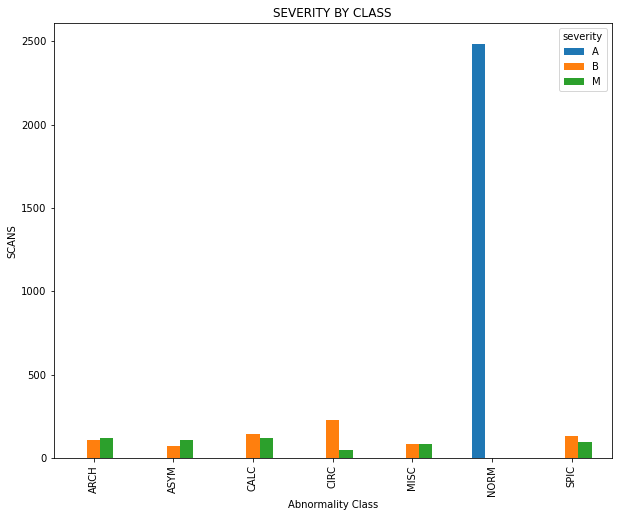

In [6]:
mias.groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar', 
                                                               figsize=(10, 8), 
                                                               xlabel='Abnormality Class', 
                                                               ylabel='SCANS',
                                                               title='SEVERITY BY CLASS')


#### Dataset balancing

Calcifications before balancing

<AxesSubplot:>

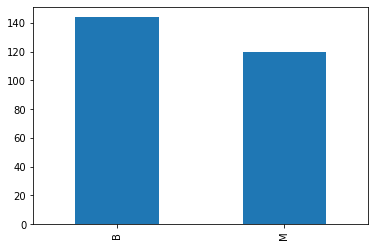

In [7]:
calcifications_unbalanced = mias[mias.ab_class == 'CALC']

calcifications_unbalanced.severity.value_counts().plot(kind='bar')

Calcifications after balancing

<AxesSubplot:>

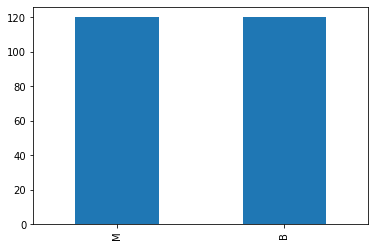

In [8]:
calcifications_balanced = hp.balance_by_severity(mias, 'CALC')

calcifications_balanced.severity.value_counts().plot(kind='bar')

### TRAIN AND EVALUATE MODEL FOR CALCIFICATIONS

In [9]:
calcifications = hp.balance_by_severity(mias, 'CALC')
calcifications

,ab_class,bg,severity,subsample_path
mdb227_180_mirr_lr,CALC,G,B,../subsamples/mdb227_180_mirr_lr.png
mdb248_270_rotated,CALC,F,B,../subsamples/mdb248_270_rotated.png
mdb214_90_mirr_lr,CALC,G,B,../subsamples/mdb214_90_mirr_lr.png
mdb212_270_mirr_tp,CALC,G,B,../subsamples/mdb212_270_mirr_tp.png
mdb226_90_rotated,CALC,D,B,../subsamples/mdb226_90_rotated.png
...,...,...,...,...
mdb256_180_mirr_lr,CALC,F,M,../subsamples/mdb256_180_mirr_lr.png
mdb256_180_mirr_tp,CALC,F,M,../subsamples/mdb256_180_mirr_tp.png
mdb256_270_rotated,CALC,F,M,../subsamples/mdb256_270_rotated.png
mdb256_270_mirr_lr,CALC,F,M,../subsamples/mdb256_270_mirr_lr.png


In [10]:
calcifications = calcifications.sample(len(calcifications), replace=False)

#### Generate Train and Test Data

In [11]:
data_generator = ImageDataGenerator(validation_split=.25, 
                                    height_shift_range=.10, 
                                    width_shift_range=.10, 
                                    rotation_range=30, 
                                    rescale=1/255.)
train_data = data_generator.flow_from_dataframe(calcifications, 
                                                x_col="subsample_path", 
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(calcifications, 
                                               x_col="subsample_path", 
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)

Found 180 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 2 classes.


In [12]:
np.unique(test_data.labels)

array([0, 1])

In [13]:
len(test_data.labels)

60

In [14]:
np.unique(train_data.labels)

array([0, 1])

In [15]:
len(train_data.labels)

180

#### Create Convolutional Neural Network

In [16]:
cnn_calc = Sequential()
# first layer
cnn_calc.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(48, 48, 1)))
cnn_calc.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
cnn_calc.add(MaxPool2D(pool_size=(2, 2)))

cnn_calc.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
cnn_calc.add(MaxPool2D(pool_size=(2, 2)))
cnn_calc.add(Dropout(0.25))
# Add dense layer to reduce the number of features
cnn_calc.add(Dense(64, activation='relu'))
cnn_calc.add(Dropout(0.25))
# flattening results
cnn_calc.add(Flatten())
# Dense layer to produce final output
cnn_calc.add(Dense(2, activation='softmax'))
# print summary
cnn_calc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 64)        0         
_________________________________________________________________
dense (Dense)                (None, 10, 10, 64)        4

#### Visualise the Model's Structure


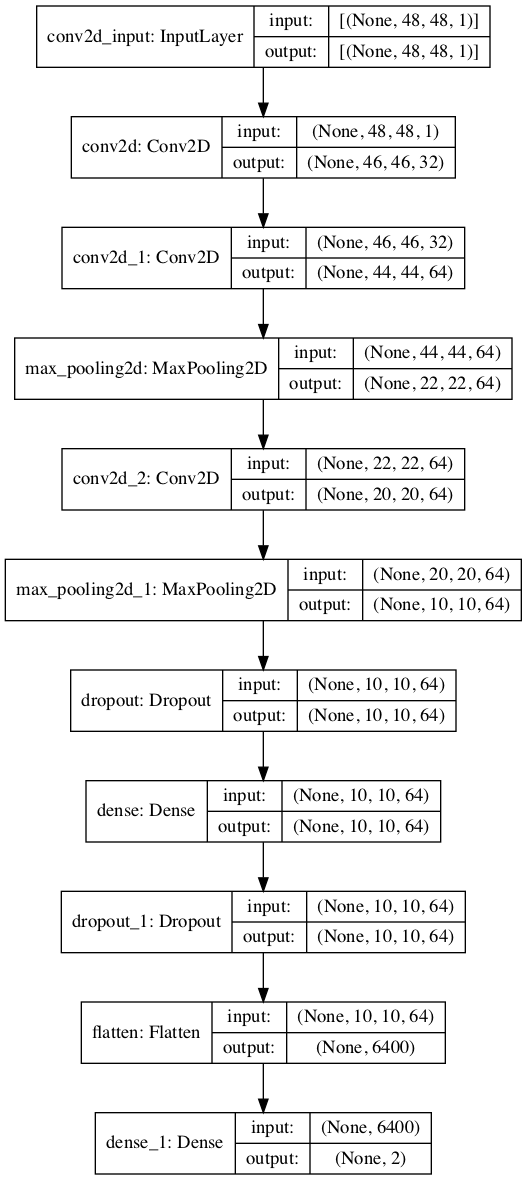

In [17]:
plot_model(cnn_calc, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

#### Compiling the model

In [18]:
adam = Adam(0.001)
cnn_calc.compile(optimizer=adam,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

#### Training and Evaluating the Model

In [ ]:
early_stopping = EarlyStopping(patience=500, restore_best_weights=True)

cnn_calc.fit(train_data, 
             validation_data=test_data, 
             epochs=500,
             callbacks=[early_stopping])

In [20]:
loss_value , accuracy = cnn_calc.evaluate(train_data)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

6/6 [==============================] - 0s 26ms/step - loss: 0.5062 - accuracy: 0.7333
Test_loss_value = 0.5061928033828735
test_accuracy = 0.7333333492279053


#### Making predictions

In [21]:
y_pred = cnn_calc.predict(test_data)
predicted = [np.argmax(w) for w in y_pred]
expected = test_data.labels

#### Confusion Matrix

In [22]:
confusion_matrix(expected, predicted)

array([[19, 10],
       [13, 18]])

#### Classification Report

In [23]:
print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.59      0.66      0.62        29
           1       0.64      0.58      0.61        31

    accuracy                           0.62        60
   macro avg       0.62      0.62      0.62        60
weighted avg       0.62      0.62      0.62        60



#### Results

In [24]:
def Visualize_Result(acc,val_acc,loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6),
                                   sharex =True)

    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')

    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')
    
    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')
    
    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    fig.savefig('Accuracy_Loss_figure.png')
    plt.tight_layout()
    plt.show()

visualize_result = Visualize_Result(hist.history['accuracy'],
                                    hist.history['val_accuracy'], 
                                    hist.history['loss'], 
                                    hist.history['val_loss'])

NameError: name 'hist' is not defined